In [57]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
import tempfile
temp_dir = tempfile.TemporaryDirectory()
from casatasks import simobserve, tclean, exportfits
import os
import shutil
from casatools import table
from astropy.constants import c
from astropy.time import Time
import astropy.units as U
from martini.sources import TNGSource
from martini import DataCube, Martini
from martini.beams import GaussianBeam
from martini.noise import GaussianNoise
from martini.spectral_models import GaussianSpectrum
from martini.sph_kernels import AdaptiveKernel, GaussianKernel, CubicSplineKernel, DiracDeltaKernel
from natsort import natsorted
import math
from math import pi
from tqdm import tqdm
import time
from time import strftime, gmtime
import dask
from typing import Optional
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from random import choices
import simulator as sim

from spectral_cube import SpectralCube
import h5py
os.environ['MPLCONFIGDIR'] = temp_dir.name
pd.options.mode.chained_assignment = None  
def get_data_from_hdf(file):
    data = list()
    column_names = list()
    r = h5py.File(file, 'r')
    for key in r.keys():
        if key == 'Snapshot_99':
            group = r[key]
            for key2 in group.keys():
                column_names.append(key2)
                data.append(group[key2])
    values = np.array(data)
    db = pd.DataFrame(values.T, columns=column_names)     
    return db   

def load_fits(inFile):
    hdu_list = fits.open(inFile)
    data = hdu_list[0].data
    header = hdu_list[0].header
    hdu_list.close()
    return data, header

def write_datacube_to_fits(
    datacube,
    filename,
    channels="frequency",
    overwrite=True,
    ):
        """
        Output the DataCube to a FITS-format file.

        Parameters
        ----------
        filename : string
            Name of the file to write. '.fits' will be appended if not already
            present.

        channels : {'frequency', 'velocity'}, optional
            Type of units used along the spectral axis in output file.
            (Default: 'frequency'.)

        overwrite: bool, optional
            Whether to allow overwriting existing files. (Default: True.)
        """

        datacube.drop_pad()
        if channels == "frequency":
            datacube.freq_channels()
        elif channels == "velocity":
            datacube.velocity_channels()
        else:
            raise ValueError(
                "Unknown 'channels' value "
                "(use 'frequency' or 'velocity'."
            )

        filename = filename if filename[-5:] == ".fits" else filename + ".fits"

        wcs_header = datacube.wcs.to_header()
        wcs_header.rename_keyword("WCSAXES", "NAXIS")

        header = fits.Header()
        header.append(("SIMPLE", "T"))
        header.append(("BITPIX", 16))
        header.append(("NAXIS", wcs_header["NAXIS"]))
        header.append(("NAXIS1", datacube.n_px_x))
        header.append(("NAXIS2", datacube.n_px_y))
        header.append(("NAXIS3", datacube.n_channels))
        header.append(("NAXIS4", 1))
        header.append(("EXTEND", "T"))
        header.append(("CDELT1", wcs_header["CDELT1"]))
        header.append(("CRPIX1", wcs_header["CRPIX1"]))
        header.append(("CRVAL1", wcs_header["CRVAL1"]))
        header.append(("CTYPE1", wcs_header["CTYPE1"]))
        header.append(("CUNIT1", wcs_header["CUNIT1"]))
        header.append(("CDELT2", wcs_header["CDELT2"]))
        header.append(("CRPIX2", wcs_header["CRPIX2"]))
        header.append(("CRVAL2", wcs_header["CRVAL2"]))
        header.append(("CTYPE2", wcs_header["CTYPE2"]))
        header.append(("CUNIT2", wcs_header["CUNIT2"]))
        header.append(("CDELT3", wcs_header["CDELT3"]))
        header.append(("CRPIX3", wcs_header["CRPIX3"]))
        header.append(("CRVAL3", wcs_header["CRVAL3"]))
        header.append(("CTYPE3", wcs_header["CTYPE3"]))
        header.append(("CUNIT3", wcs_header["CUNIT3"]))
        header.append(("CDELT4", wcs_header["CDELT4"]))
        header.append(("CRPIX4", wcs_header["CRPIX4"]))
        header.append(("CRVAL4", wcs_header["CRVAL4"]))
        header.append(("CTYPE4", wcs_header["CTYPE4"]))
        header.append(("CUNIT4", "PAR"))
        header.append(("EPOCH", 2000))
        # header.append(('BLANK', -32768)) #only for integer data
        header.append(("BSCALE", 1.0))
        header.append(("BZERO", 0.0))
        datacube_array_units = datacube._array.unit
        header.append(
            ("DATAMAX", np.max(datacube._array.to_value(datacube_array_units)))
        )
        header.append(
            ("DATAMIN", np.min(datacube._array.to_value(datacube_array_units)))
        )
        
        # long names break fits format, don't let the user set this
        header.append(("OBJECT", "MOCK"))
        header.append(("BUNIT", datacube_array_units.to_string("fits")))
        header.append(("MJD-OBS", Time.now().to_value("mjd")))
        header.append(("BTYPE", "Intensity"))
        header.append(("SPECSYS", wcs_header["SPECSYS"]))

        # flip axes to write
        hdu = fits.PrimaryHDU(
            header=header, data=datacube._array.to_value(datacube_array_units).T
        )
        hdu.writeto(filename, overwrite=overwrite)

        if channels == "frequency":
            datacube.velocity_channels()
        return

def plot_moments(FluxCube, vch, path):
    np.seterr(all='ignore')
    fig = plt.figure(figsize=(16, 5))
    sp1 = fig.add_subplot(1,3,1)
    sp2 = fig.add_subplot(1,3,2)
    sp3 = fig.add_subplot(1,3,3)
    rms = np.std(FluxCube[:16, :16])  # noise in a corner patch where there is little signal
    clip = np.where(FluxCube > 5 * rms, 1, 0)
    mom0 = np.sum(FluxCube, axis=-1)
    mask = np.where(mom0 > .02, 1, np.nan)
    mom1 = np.sum(FluxCube * clip * vch, axis=-1) / mom0
    mom2 = np.sqrt(np.sum(FluxCube * clip * np.power(vch - mom1[..., np.newaxis], 2), axis=-1)) / mom0
    im1 = sp1.imshow(mom0.T, cmap='Greys', aspect=1.0, origin='lower')
    plt.colorbar(im1, ax=sp1, label='mom0 [Jy/beam]')
    im2 = sp2.imshow((mom1*mask).T, cmap='RdBu', aspect=1.0, origin='lower')
    plt.colorbar(im2, ax=sp2, label='mom1 [km/s]')
    im3 = sp3.imshow((mom2*mask).T, cmap='magma', aspect=1.0, origin='lower', vmin=0, vmax=300)
    plt.colorbar(im3, ax=sp3, label='mom2 [km/s]')
    for sp in sp1, sp2, sp3:
        sp.set_xlabel('x [px = arcsec/10]')
        sp.set_ylabel('y [px = arcsec/10]')
    plt.subplots_adjust(wspace=.3)
    plt.savefig(path)

In [4]:
file = 'morphologies_deeplearn.hdf5'
db = get_data_from_hdf(file)
db.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12535 entries, 0 to 12534
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   P_Late      12535 non-null  float64
 1   P_S0        12535 non-null  float64
 2   P_Sab       12535 non-null  float64
 3   Sigma_Late  12535 non-null  float64
 4   Sigma_S0    12535 non-null  float64
 5   Sigma_Sab   12535 non-null  float64
 6   SubhaloID   12535 non-null  float64
dtypes: float64(7)
memory usage: 685.6 KB


In [49]:
catalogue = db[['SubhaloID', 'P_Late', 'P_S0', 'P_Sab']]
catalogue.sort_values(by=['P_Late'], inplace=True, ascending=False)
catalogue.head(10)
ellipticals = catalogue[(catalogue['P_Late'] > 0.6) & (catalogue['P_S0'] < 0.5) & (catalogue['P_Sab'] < 0.5)]
lenticulars = catalogue[(catalogue['P_S0'] > 0.6) & (catalogue['P_Late'] < 0.5) & (catalogue['P_Sab'] < 0.5)]
spirals = catalogue[(catalogue['P_Sab'] > 0.6) & (catalogue['P_Late'] < 0.5) & (catalogue['P_S0'] < 0.5)]

ellipticals['sum'] = ellipticals['P_S0'].values + ellipticals['P_Sab'].values
lenticulars['sum'] = lenticulars['P_Late'].values + lenticulars['P_Sab'].values

spirals['sum'] = spirals['P_Late'].values + spirals['P_S0'].values
ellipticals.sort_values(by=['sum'], inplace=True, ascending=True)
lenticulars.sort_values(by=['sum'], inplace=True, ascending=True)
spirals.sort_values(by=['sum'], inplace=True, ascending=True)
ellipticals_ids = ellipticals['SubhaloID'].values
lenticulars_ids = lenticulars['SubhaloID'].values
spirals_ids = spirals['SubhaloID'].values

print(len(ellipticals), len(lenticulars), len(spirals))
n = 100
sample_n = 100 // 3

n_0 = choices(ellipticals_ids, k=sample_n)
n_1 = choices(lenticulars_ids, k=sample_n)
n_2 = choices(spirals_ids, k=n - 2 * sample_n)
ids = np.concatenate((n_0, n_1, n_2))
print(len(ids))



117 1927 191
100


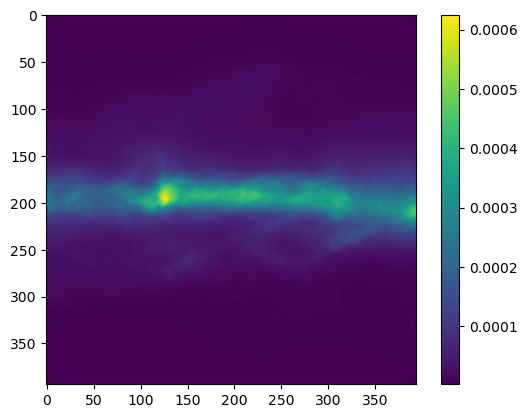

In [54]:
data_dir = '/media/storage/extended_sims_test_0'
extended, extended_header = load_fits(os.path.join(data_dir, 'skymodel_2.fits'))
#gaussian, gaussian_header = load_fits(os.path.join(data_dir, 'skymodel_1.fits'))
#print(extended.shape, gaussian.shape)


plt.imshow(np.sum(extended[0,:,:], axis=0))
plt.colorbar()
plt.show()
#plt.imshow(np.sum(gaussian[0,:,:], axis=0))
#plt.colorbar()


In [129]:
def _gen_particle_coords(source, datacube):
    # pixels indexed from 0 (not like in FITS!) for better use with numpy
    origin = 0
    skycoords = source.sky_coordinates
    return (
        np.vstack(
            datacube.wcs.sub(3).wcs_world2pix(
                skycoords.ra.to(datacube.units[0]),
                skycoords.dec.to(datacube.units[1]),
                skycoords.radial_velocity.to(datacube.units[2]),
                origin,
            )
        )
        * U.pix
    )

def get_sizes(source, n_px, n_channels):
    
    px_size = 10.0 * U.arcsec
    channel_width=16.0 * U.km * U.s**-1
    datacube = DataCube(
        n_px_x = n_px,
        n_px_y = n_px,
        n_channels = n_channels, 
        px_size = px_size,
        channel_width=channel_width,
        velocity_centre=source.vsys, 
        ra = source.ra,
        dec = source.dec,
    )
    coordinates = _gen_particle_coords(source, datacube)
    min_x, max_x = np.min(coordinates[0,:]), np.max(coordinates[0,:])
    min_y, max_y = np.min(coordinates[1,:]), np.max(coordinates[1,:])
    min_z, max_z = np.min(coordinates[2,:]), np.max(coordinates[2,:])
    while (min_x < 0 * U.pix) or (max_x > n_px * U.pix) or (min_y < 0 * U.pix) or (max_y > n_px * U.pix):
        px_size += 1.0 * U.arcsec
        datacube = DataCube(
            n_px_x = n_px,
            n_px_y = n_px,
            n_channels = n_channels, 
            px_size = px_size,
            channel_width=channel_width,
            velocity_centre=source.vsys, 
            ra = source.ra,
            dec = source.dec,
        )
        coordinates = _gen_particle_coords(source, datacube)
        min_x, max_x = np.min(coordinates[0,:]), np.max(coordinates[0,:])
        min_y, max_y = np.min(coordinates[1,:]), np.max(coordinates[1,:])
        min_z, max_z = np.min(coordinates[2,:]), np.max(coordinates[2,:])
        
    while (min_z < 0 * U.pix) or (max_z > n_channels * U.pix):
        channel_width += 1.0 * U.km * U.s**-1
        datacube = DataCube(
            n_px_x = n_px,
            n_px_y = n_px,
            n_channels = n_channels, 
            px_size = px_size,
            channel_width=channel_width,
            velocity_centre=source.vsys, 
            ra = source.ra,
            dec = source.dec,
        )
        coordinates = _gen_particle_coords(source, datacube)
        min_z, max_z = np.min(coordinates[2,:]), np.max(coordinates[2,:])
    
    coordinates = _gen_particle_coords(source, datacube)
    min_x, max_x = np.min(coordinates[0,:]), np.max(coordinates[0,:])
    min_y, max_y = np.min(coordinates[1,:]), np.max(coordinates[1,:])
    min_z, max_z = np.min(coordinates[2,:]), np.max(coordinates[2,:])
    assert (min_x >= 0* U.pix) and (max_x <= n_pxs* U.pix) and (min_y >= 0* U.pix) and (max_y <= n_pxs* U.pix ), "Source cannot be fitted to cube dimensions"
    return px_size, channel_width 

def get_distance(n_px, n_channels, 
                 x_rot, y_rot, simulation_str, TNGSnapshotID, TNGSubhaloID, 
                 api_key, data_dir):
    distance = 1 * U.Mpc
    source = TNGSource(simulation_str, TNGSnapshotID, TNGSubhaloID,
                       distance=distance,
                       rotation = {'L_coords': (x_rot, y_rot)},
                       cutout_dir = data_dir,
                       api_key = api_key,
                       ra = 0. * U.deg,
                       dec = 0. * U.deg,
                       )
    datacube = DataCube(
        n_px_x = n_px,
        n_px_y = n_px,
        n_channels = n_channels, 
        px_size = 10.0 * U.arcsec,
        channel_width=10.0 * U.km * U.s**-1,
        velocity_centre=source.vsys, 
        ra = source.ra,
        dec = source.dec,
    )
    coordinates = _gen_particle_coords(source, datacube)
    min_x, max_x = np.min(coordinates[0,:]), np.max(coordinates[0,:])
    min_y, max_y = np.min(coordinates[1,:]), np.max(coordinates[1,:])
    min_z, max_z = np.min(coordinates[2,:]), np.max(coordinates[2,:])
    while (min_x < 0 * U.pix) or (max_x > n_px * U.pix) or (min_y < 0 * U.pix) or (max_y > n_px * U.pix):
        distance += 10 * U.Mpc
        source = TNGSource(simulation_str, TNGSnapshotID, TNGSubhaloID,
                       distance=distance,
                       rotation = {'L_coords': (x_rot, y_rot)},
                       cutout_dir = os. getcwd(),
                       api_key = api_key,
                       ra = 0. * U.deg,
                       dec = 0. * U.deg,)
    
        datacube = DataCube(
            n_px_x = n_px,
            n_px_y = n_px,
            n_channels = n_channels, 
            px_size = 10.0 * U.arcsec,
            channel_width=10.0 * U.km * U.s**-1,
            velocity_centre=source.vsys, 
            ra = source.ra,
            dec = source.dec,
        )
        coordinates = _gen_particle_coords(source, datacube)
        min_x, max_x = np.min(coordinates[0,:]), np.max(coordinates[0,:])
        min_y, max_y = np.min(coordinates[1,:]), np.max(coordinates[1,:])
    source = TNGSource(simulation_str, TNGSnapshotID, TNGSubhaloID,
                       distance=distance,
                       rotation = {'L_coords': (x_rot, y_rot)},
                       cutout_dir = os. getcwd(),
                       api_key = api_key,
                       ra = 0. * U.deg,
                       dec = 0. * U.deg,)
    channel_width=10.0 * U.km * U.s**-1
    while (min_z < 0 * U.pix) or (max_z > n_channels * U.pix):
        channel_width += 1.0 * U.km * U.s**-1
        datacube = DataCube(
            n_px_x = n_px,
            n_px_y = n_px,
            n_channels = n_channels, 
            px_size = 10.0 * U.arcsec,
            channel_width=channel_width,
            velocity_centre=source.vsys, 
            ra = source.ra,
            dec = source.dec,
        )
        coordinates = _gen_particle_coords(source, datacube)
        min_z, max_z = np.min(coordinates[2,:]), np.max(coordinates[2,:])
        
    return distance, channel_width

In [128]:
id = 0
data_dir = '/media/storage'
main_path = '/home/deepfocus/ALMASim'
plot_dir = 'extended_plots'
output_dir = 'extended_sims_test_0'
project_name = 'sim'
band = 6
antenna_name = 'alma.cycle9.3.3'
inbright = 0.01
bandwidth = 1280
inwidth = 10
integration = 10
totaltime = 4500
pwv = 0.3
snr = 30
get_skymodel = False
extended = True
TNGBasePath = '/media/storage/TNG100-1'
TNGSnapshotID = 99
TNGSubhaloID = 487363
api_key = "8f578b92e700fae3266931f4d785f82c"
plot = True
save_ms = False
crop = False
n_pxs = None
n_channels = None



spatial_resolution = sim.get_spatial_resolution(band, antenna_name) 
central_freq= sim.get_band_central_freq(band)
fov = sim.get_fov([band])[0]
pixel_size = spatial_resolution / 7
n_px = int(1.5 * fov / pixel_size)
if n_channels is None:
    n_channels = int(bandwidth / inwidth)

In [130]:


x_rot = np.random.randint(0, 360) * U.deg
y_rot = np.random.randint(0, 360) * U.deg
simulation_str = TNGBasePath.split('/')[-1]
frequency_resolution  = inwidth * U.MHz
spatial_resolution = spatial_resolution * U.arcsec

central_frequency = central_freq * U.GHz
#px_size, channel_width = get_sizes(source, n_pxs, n_channels)
#print(px_size, channel_width)
hI_rest_frequency = 1420.4 * U.MHz
radio_hI_equivalence = U.doppler_radio(hI_rest_frequency)
velocity_resolution = frequency_resolution.to(U.km / U.s, equivalencies=radio_hI_equivalence)

distance, channel_width = get_distance(n_px, n_channels, x_rot, y_rot,
                         simulation_str, TNGSnapshotID, TNGSubhaloID, api_key, output_dir)
print(distance, channel_width)


No local cutout found, cutout will be downloaded.
Writing downloaded cutout to martini-cutout-TNG100-1-99-1542.hdf5
No local cutout found, cutout will be downloaded.
Writing downloaded cutout to martini-cutout-TNG100-1-99-1542.hdf5
No local cutout found, cutout will be downloaded.
Writing downloaded cutout to martini-cutout-TNG100-1-99-1542.hdf5
No local cutout found, cutout will be downloaded.
Writing downloaded cutout to martini-cutout-TNG100-1-99-1542.hdf5
No local cutout found, cutout will be downloaded.
Writing downloaded cutout to martini-cutout-TNG100-1-99-1542.hdf5
No local cutout found, cutout will be downloaded.
Writing downloaded cutout to martini-cutout-TNG100-1-99-1542.hdf5
41.0 Mpc 27.0 km / s


In [132]:
source = TNGSource(simulation_str, TNGSnapshotID, TNGSubhaloID,
                       distance=distance,
                       rotation = {'L_coords': (x_rot, y_rot)},
                       cutout_dir = TNGBasePath,
                       api_key = api_key,
                       ra = 0. * U.deg,
                       dec = 0. * U.deg,)
datacube = DataCube(
        n_px_x = n_px,
        n_px_y = n_px,
        n_channels = n_channels, 
        px_size = 10.0 * U.arcsec,
        channel_width=channel_width,
        velocity_centre=source.vsys, 
        ra = source.ra,
        dec = source.dec,
    )

spectral_model = GaussianSpectrum(
        sigma="thermal"
    )
sph_kernel = AdaptiveKernel(
    (
        CubicSplineKernel(),
        GaussianKernel(truncate=6)
    ), verbose=False
    )

M = Martini(
        source=source,
        datacube=datacube,
        sph_kernel=sph_kernel,
        spectral_model=spectral_model)
    
M.insert_source_in_cube(skip_validation=True)

No local cutout found, cutout will be downloaded.
Writing downloaded cutout to martini-cutout-TNG100-1-99-1542.hdf5
Source module contained 89450 particles with total HI mass of 1.03e+11 solMass.
Pruned particles that will not contribute to data cube, 89450 particles remaining with total HI mass of 1.03e+11 solMass.
    ---------AdaptiveKernel VALIDATION---------
    Median smoothing length:  1.5752039455745848 pix px
    Minimum smoothing length:  0.21278003465386533 pix px
    Maximum smoothing length:  18.84124258125299 pix px
    Smoothing length histogram (np.histogram): (array([50813, 11049,  7546,  9899,  7823,  1844,   361,    86,    24,
           5]), <Quantity [ 0.21278003,  2.07562629,  3.93847254,  5.8013188 ,  7.66416505,
            9.52701131, 11.38985756, 13.25270382, 15.11555007, 16.97839633,
           18.84124258] pix>)
     1260 / 89450 smoothing lengths fail validation.
    -------------------------------------------
Inserting source in cube.


100%|██████████| 155236/155236 [02:24<00:00, 1074.30it/s]


Source inserted.
  Flux in cube: 9.55e+00 Jy
  Mass in cube (assuming distance 41.00 Mpc): 1.02e+11 solMass
    [99% of initial source mass]
  Maximum pixel: 6.07e-05 Jy / arcsec2
  Median non-zero pixel: 1.67e-13 Jy / arcsec2


Skymodel saved to /media/storage/skymodel_0.fits
(394, 394, 128, 1)


FileNotFoundError: [Errno 2] No such file or directory: 'extended_plots/skymodel_0.png'

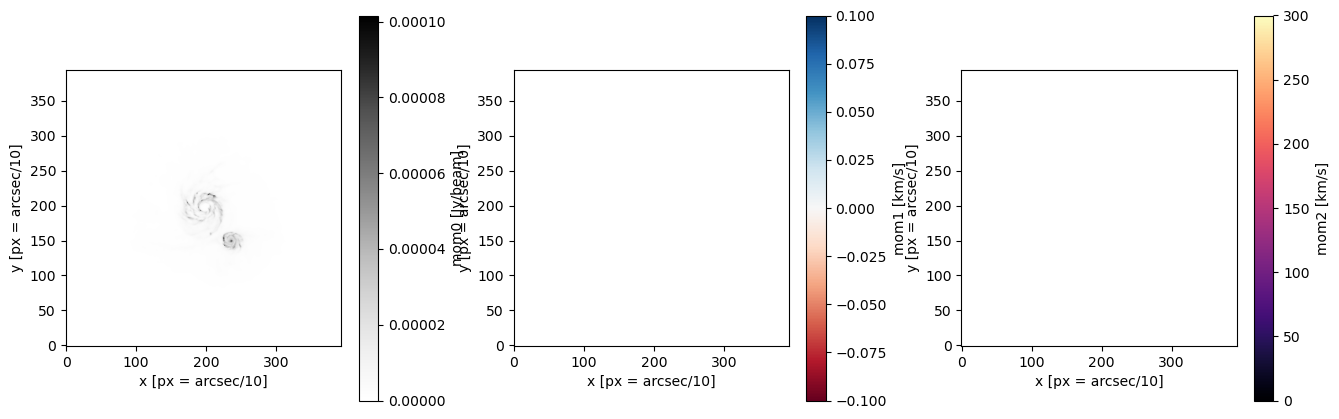

In [133]:
M.write_hdf5(os.path.join(data_dir, 'skymodel_{}.hdf5'.format(str(id))), channels='velocity')
f = h5py.File(os.path.join(data_dir, 'skymodel_{}.hdf5'.format(str(id))),'r')
vch = f['channel_mids'][()] / 1E3 - source.distance.to(U.Mpc).value*70  # m/s to km/s
f.close()
os.remove(os.path.join(data_dir, 'skymodel_{}.hdf5'.format(str(id))))
filename = os.path.join(data_dir, 'skymodel_{}.fits'.format(id))
#M.write_fits(filename, channels='velocity')
write_datacube_to_fits(M.datacube, filename)
print('Skymodel saved to {}'.format(filename))
if plot is True:
    SkyCube = M.datacube._array.value
print(SkyCube.shape)
plot_moments(SkyCube[:, :, :, 0], vch, os.path.join(plot_dir, 'skymodel_{}.png'.format(str(id))))